# **Проект: Предсказание успешности стартапов**

Цель: создать модель для прогнозирования закрытия стартапа.
Описание полей данных:
name - Название стартапа
`category_list` - Список категорий, к которым относится стартап
`funding_total_usd` - Общая сумма финансирования в USD
`status` - Статус стартапа (закрыт или действующий) - целевой признак
`country_code` - Код страны
`state_code` - Код штата
`region` - Регион
`city` - Город
`funding_rounds` - Количество раундов финансирования
`founded_at` - Дата основания
`first_funding_at` - Дата первого раунда финансирования
`last_funding_at` - Дата последнего раунда финансирования
`closed_at` - Дата закрытия стартапа (если применимо)

Информация за период с 1980 по 2018

## Загрузка необходимых библиотек

In [1]:
!pip -q install -U pandas

In [2]:
!pip -q install imblearn
!pip -q install feature_engine
# !pip -q install scikit-learn==1.1.3 -q
!pip -q install --upgrade shap -q
!pip -q install phik seaborn -q
!pip -q install -q imbalanced-learn

In [5]:
# Импортируем необходимые библиотеки
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import seaborn as sns
from phik import phik_matrix
import numpy as np

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures,FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer

# загружаем класс для работы с пропусками
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# загрузим необходимые библиотеки для создания пайплайна
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures

# from imblearn.combine import SMOTETomek
# from imblearn.base import FunctionSampler
# from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures
from sklearn.metrics import classification_report
import time
from tqdm.auto import tqdm

# изменим формат представления чисел с плавающей точкой
pd.set_option('display.float_format', '{:,.2f}'.format)



## Изучение и подготовка данных

In [6]:
# загрузим таблицы и выведем основную информацию
startups_train=pd.read_csv('/content/kaggle_startups_train_01.csv',sep=",", decimal='.',parse_dates=['founded_at','first_funding_at','last_funding_at','closed_at'])
display('table: startups_train', startups_train)
print(startups_train.info())
startups_test=pd.read_csv('/content/kaggle_startups_test_01.csv',sep=",", decimal='.',parse_dates=['founded_at','first_funding_at','last_funding_at','closed_at'])
display('table: startups_test', startups_test)
print(startups_test.info())

'table: startups_train'

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,"22,250,000.00",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52874,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52875,Hello Curry,Hospitality,"500,000.00",operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,NaT
52876,Taskforce,Email|Messaging|Productivity Software,"50,000.00",operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52877,NetScaler,Security,"13,000,000.00",operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52878 non-null  object        
 1   category_list      50374 non-null  object        
 2   funding_total_usd  42753 non-null  float64       
 3   status             52879 non-null  object        
 4   country_code       47351 non-null  object        
 5   state_code         46082 non-null  object        
 6   region             46489 non-null  object        
 7   city               46489 non-null  object        
 8   funding_rounds     52879 non-null  int64         
 9   founded_at         52879 non-null  datetime64[ns]
 10  first_funding_at   52858 non-null  datetime64[ns]
 11  last_funding_at    52879 non-null  datetime64[ns]
 12  closed_at          4962 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

'table: startups_test'

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,"2,819,200.00",NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaT
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaT
2,COINPLUS,Finance,"428,257.00",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaT
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.00",USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaT
4,DNA13,Software,"4,530,000.00",CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
13206,Jymob,Recruiting,"28,000.00",USA,CA,SF Bay Area,Sunnyvale,1,2011-12-06,2012-07-01,2012-07-01,NaT
13207,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2012-01-01,2013-10-01,2013-10-01,NaT
13208,Inkd.com,Design|E-Commerce|Marketplaces|Printing,"5,600,000.00",USA,WA,Seattle,Seattle,3,2010-01-01,2008-09-01,2011-06-28,NaT
13209,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,"150,000.00",USA,NY,New York City,New York,2,2012-12-04,2014-09-27,2014-11-04,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13211 non-null  object        
 1   category_list      12610 non-null  object        
 2   funding_total_usd  10616 non-null  float64       
 3   country_code       11827 non-null  object        
 4   state_code         11512 non-null  object        
 5   region             11618 non-null  object        
 6   city               11620 non-null  object        
 7   funding_rounds     13211 non-null  int64         
 8   founded_at         13211 non-null  datetime64[ns]
 9   first_funding_at   13211 non-null  datetime64[ns]
 10  last_funding_at    13211 non-null  datetime64[ns]
 11  closed_at          1234 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(6)
memory usage: 1.2+ MB
None


В данных есть пропуски, которые нужно обработать, также нужно проверить дубликаты явные и неявные

In [7]:
# переведем категориальные столбцы в нижний регистр и удалим пробелы
cat_col=['name','category_list','country_code','state_code','region','city']
startups_train[cat_col]=startups_train[cat_col].map(lambda x: x.lower() if isinstance(x, str) else x)
startups_train[cat_col]=startups_train[cat_col].map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

startups_test[cat_col]=startups_test[cat_col].map(lambda x: x.lower() if isinstance(x, str) else x)
startups_test[cat_col]=startups_test[cat_col].map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

In [8]:
# Проверим, есть ли явные дубликаты
print('startups_train:',startups_train.duplicated().sum())

startups_train: 0


In [9]:
# Проверим, есть ли явные дубликаты в разрезе название компании, город, дата открытия
startups_train[startups_train[['name','city','founded_at']].duplicated()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
28391,pureenergysolutions,hardware+software,"14,766,689.00",operating,usa,co,denver,boulder,2,2005-01-01,2009-02-19,2010-05-05,NaT
47323,artsper,art,"1,684,764.31",operating,fra,a8,paris,paris,2,2013-02-28,2014-03-27,2015-11-27,NaT


In [10]:
startups_train.loc[(startups_train['name']=='pureenergysolutions') | (startups_train['name']=='artsper')]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3279,artsper,art|e-commerce|marketplaces|saas,"413,177.00",operating,fra,a8,paris,paris,1,2013-02-28,2014-04-01,2014-04-01,NaT
16152,pureenergysolutions,hardware+software,"7,729,998.00",closed,usa,co,denver,boulder,1,2005-01-01,2009-11-09,2009-11-09,2011-06-04
28391,pureenergysolutions,hardware+software,"14,766,689.00",operating,usa,co,denver,boulder,2,2005-01-01,2009-02-19,2010-05-05,NaT
47323,artsper,art,"1,684,764.31",operating,fra,a8,paris,paris,2,2013-02-28,2014-03-27,2015-11-27,NaT


Дубликаты есть и я подозреваю, что дубликаты этих компаний являются их дочерними компаниями, поэтому удалять я их не буду.

### Обработка пропусков

In [11]:
#Обработаем пропуски в географии
# пропуски в country_code заменим на моду
startups_train['country_code']=startups_train['country_code'].fillna(startups_train['country_code'].mode()[0])
startups_train['region'] = startups_train.groupby('country_code')['region'].transform(lambda x: x.fillna(x.mode(dropna=True).iloc[0] if not x.mode(dropna=True).empty else startups_train['region'].mode().iloc[0]))
startups_train['state_code'] = startups_train.groupby('region')['state_code'].transform(lambda x: x.fillna(x.mode(dropna=True).iloc[0] if not x.mode(dropna=True).empty else startups_train['state_code'].mode().iloc[0]))
startups_train['city'] = startups_train.groupby('region')['city'].transform(lambda x: x.fillna(x.mode(dropna=True).iloc[0] if not x.mode(dropna=True).empty else startups_train['city'].mode().iloc[0]))
# Пропуск в name заменим на NA
startups_train.loc[startups_train['name'].isna(),'name']='NA'

Проанализировав данные, можно отметить, что столбец state_code имеет повторяющиеся значения в разных странахи больше всего пропусков среди географических столбцов. Столбец регион имеет много неправильных данных: например palermo отновится к региону Буйенос-Айрес, а не к arg-other. Подозреваю, что регионы с приставкой other - придуманы для того, чтобы заполнить пропуски. Еще одна странность - не понятно, что за стобец state_code, в открытыйх источниках данных я не нашла таких кодов штатов, например для аргентины. Странно, что один и тот же регион принадлежит к разных кодам штатов. В открытх источниках данных таких кодов штатов, например для ОАЭ или Аргентины я не нашла.
В тренировочных данных больше регионов и стран, чем в тестовых. Это необходимо будет учесть при кодировке.

пропуски в географии обработаны, теперь обработаем пропуски в датах.
Для начала изучим значения во всем столбцах с датами

In [12]:
startups_train['founded_at'].describe()

count                            52879
mean     2008-05-10 09:36:44.769379328
min                1749-01-01 00:00:00
25%                2006-07-09 12:00:00
50%                2010-09-03 00:00:00
75%                2012-12-27 00:00:00
max                2105-02-17 00:00:00
Name: founded_at, dtype: object

In [13]:
startups_train['closed_at'].describe()

count                             4962
mean     2012-01-05 17:08:11.898428160
min                1972-09-06 00:00:00
25%                2009-09-25 06:00:00
50%                2012-09-02 12:00:00
75%                2015-04-17 18:00:00
max                2106-07-20 00:00:00
Name: closed_at, dtype: object

In [14]:
startups_train['first_funding_at'].describe()

count                            52858
mean     2011-07-16 01:49:32.598281984
min                1960-01-01 00:00:00
25%                2009-10-10 00:00:00
50%                2012-07-25 00:00:00
75%                2014-04-01 00:00:00
max                2015-12-05 00:00:00
Name: first_funding_at, dtype: object

In [15]:
startups_train['last_funding_at'].describe()

count                            52879
mean     2012-06-27 00:37:11.933281792
min                1971-01-01 00:00:00
25%                2011-02-01 00:00:00
50%                2013-09-01 00:00:00
75%                2014-11-16 00:00:00
max                2115-12-01 00:00:00
Name: last_funding_at, dtype: object

В столбцах есть аномалии, заполним их граничными значениями (1980 и 2018) либо founded_at и closed_at. Значения в closed_at заменим на верхнюю граничную дату. Это нам понадобится для создания новых признаков, которыми мы будем заменять столбцы с датами.

In [16]:
startups_train['founded_at'] = startups_train['founded_at'].apply(lambda x: x.replace(year=1980) if x.year < 1980 else x)
startups_train['founded_at'] = startups_train['founded_at'].apply(lambda x: x.replace(year=2018) if x.year > 2018 else x)
startups_train['closed_at'] = startups_train['closed_at'].apply(lambda x: x.replace(year=1980) if x.year < 1980 else x)
startups_train['closed_at'] = startups_train['closed_at'].apply(lambda x: x.replace(year=2018) if x.year > 2018 else x)
startups_train['last_funding_at'] = startups_train['last_funding_at'].apply(lambda x: x.replace(year=2018) if x.year > 2018 else x)
startups_train['first_funding_at']=startups_train['first_funding_at'].fillna(startups_train['founded_at'])
startups_train['last_funding_at']=startups_train['last_funding_at'].fillna(startups_train['closed_at'])
startups_train['closed_at']=startups_train['closed_at'].fillna(pd.to_datetime('2018-01-01'))

In [17]:
# создадим признак lifetime
startups_train['lifetime']=(startups_train['closed_at']-startups_train['founded_at']).dt.days
# создадим признак days_before_first_funding
startups_train['days_before_first_funding']=(startups_train['first_funding_at']-startups_train['founded_at']).dt.days
# создадим признак средняя длительность между раундами финансирования
startups_train['avg_gap_between_fund']=((startups_train['last_funding_at']-startups_train['first_funding_at'])/startups_train['funding_rounds']).dt.days

In [18]:
startups_train.head(50)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,days_before_first_funding,avg_gap_between_fund
0,lunchgate,onlinereservations|restaurants,"828,626.00",operating,che,25,zurich,zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01,2748,311,655
1,earlens,manufacturing|medical|medicaldevices,"42,935,019.00",operating,usa,ca,sfbayarea,redwoodcity,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,1949,348
2,revivapharmaceuticals,biotechnology,"35,456,381.00",operating,usa,ca,sfbayarea,sanjose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,2423,227
3,sancilioandcompany,healthcare,"22,250,000.00",operating,usa,ca,sfbayarea,sanfrancisco,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,2800,350
4,wiretoughcylinders,manufacturing,NaN,operating,usa,va,va-other,bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01,2712,551,0
5,connectedsportsventures,mobile,"4,300,000.00",operating,usa,nj,newark,princeton,1,2011-04-21,2012-11-12,2012-11-12,2018-01-01,2447,571,0
6,attensity,analytics|businessanalytics|socialcrm|socialme...,"90,000,000.00",operating,usa,ca,sfbayarea,redwoodcity,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,5247,0
7,meshnetworks,software,"4,300,000.00",operating,usa,tx,houston,houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,3599,0
8,angioscore,biotechnology,"42,000,000.00",operating,usa,ca,sfbayarea,fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,1742,644
9,vidatronic,semiconductors,"1,250,500.00",operating,usa,tx,austin,collegestation,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,599,288


In [19]:
startups_train = startups_train.drop(columns=['first_funding_at','last_funding_at','closed_at','founded_at'])

Столбцы с датами обработаны, перейдем к funding_total_usd

In [20]:
 #Изучим основную информацию и пропуски
startups_train['funding_total_usd'].describe()

count           42,753.00
mean        18,930,591.12
std        205,328,789.59
min                  1.00
25%            340,000.00
50%          2,000,000.00
75%         10,000,000.00
max     30,079,503,000.00
Name: funding_total_usd, dtype: float64

<Axes: >

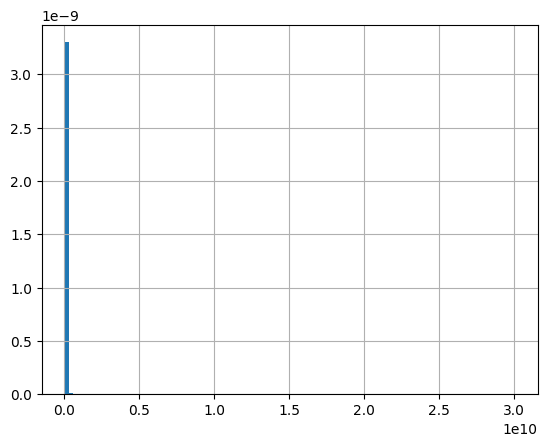

In [21]:
startups_train['funding_total_usd'].hist(bins=100, density=True)

In [27]:
startups_train[startups_train['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,days_before_first_funding,avg_gap_between_fund
4,wiretoughcylinders,manufacturing,NaN,operating,usa,va,va-other,bristol,1,2712,551,0
10,indievinos,software,NaN,operating,usa,or,"portland,oregon",portland,1,3287,1571,0
16,salesjob,NaN,NaN,closed,usa,ca,sfbayarea,sanfrancisco,1,998,294,0
24,savasti,NaN,NaN,closed,usa,ca,sfbayarea,sanfrancisco,1,443,0,0
25,brightree,software,NaN,operating,usa,ga,atlanta,lawrenceville,1,3763,306,0
...,...,...,...,...,...,...,...,...,...,...,...,...
52862,stockradar,finance|fintech,NaN,operating,chn,22,beijing,beijing,3,2557,334,463
52865,zura!,e-commerce,NaN,operating,bra,27,bra-other,brasil,1,4230,577,0
52870,proactivecomfort,medical,NaN,operating,usa,md,baltimore,centreville,1,2999,461,0
52871,scramcard,NaN,NaN,operating,hkg,ca,hongkong,hongkong,1,1826,1053,0


Видно, что есть очень большие аномалии, от которых нужно избавиться, выявим % таких аномальных значений

In [28]:
startups_train['funding_total_usd'].quantile(0.95)

69000000.0

95% значений меньше, чем 46 млн. Заменим 5% самых больших значений на 95 перцентиль

In [29]:
startups_train.loc[startups_train['funding_total_usd']>startups_train['funding_total_usd'].quantile(0.95),'funding_total_usd']=startups_train['funding_total_usd'].quantile(0.95)

In [30]:
# пропуски заменим медианой группируя данные по стране и кол-ву раундов
startups_train['funding_total_usd'] = startups_train.groupby(['country_code', 'funding_rounds'])['funding_total_usd'].transform(lambda x: x.fillna(x.median()))
startups_train['funding_total_usd'] = startups_train.groupby(['funding_rounds'])['funding_total_usd'].transform(lambda x: x.fillna(x.median()))

In [31]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       52879 non-null  object 
 1   category_list              50374 non-null  object 
 2   funding_total_usd          52879 non-null  float64
 3   status                     52879 non-null  object 
 4   country_code               52879 non-null  object 
 5   state_code                 52879 non-null  object 
 6   region                     52879 non-null  object 
 7   city                       52879 non-null  object 
 8   funding_rounds             52879 non-null  int64  
 9   lifetime                   52879 non-null  int64  
 10  days_before_first_funding  52879 non-null  int64  
 11  avg_gap_between_fund       52879 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 4.8+ MB


<Axes: >

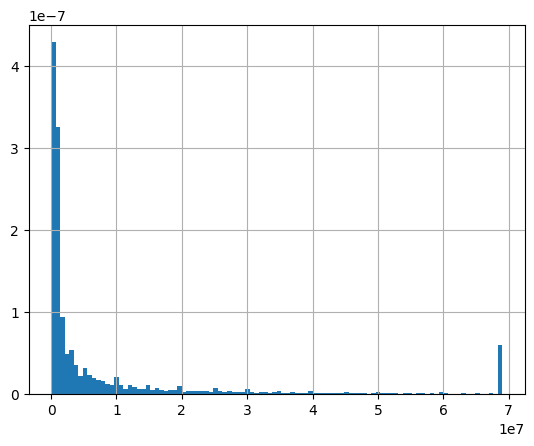

In [32]:
startups_train['funding_total_usd'].hist(bins=100, density=True)

In [33]:
# Создадим столбец с разделением на  3 категории объема финансирования
bins = [0, startups_train['funding_total_usd'].quantile(0.35), startups_train['funding_total_usd'].quantile(0.75), float('inf')]
labels = ['Low', 'Medium', 'High']

# Apply the cut function to create the categorical variable
startups_train['funding_group'] = pd.cut(startups_train['funding_total_usd'], bins=bins, labels=labels, right=False)


startups_train['funding_group'].value_counts()

funding_group
Medium    21457
Low       18084
High      13338
Name: count, dtype: int64

Финасовые показатели обработали, перейдем к столбцу с категориями category_list

In [34]:
# изучим сколько всего у нас уникальных значений категорий
len(startups_train['category_list'].unique())

22197

In [35]:
# посмотрим первые 50 категорий
startups_train['category_list'].value_counts().head(50)

category_list
software                           3216
biotechnology                      2917
e-commerce                         1067
mobile                              921
cleantechnology                     896
curatedweb                          857
healthcare                          750
hardware+software                   747
games                               682
enterprisesoftware                  675
healthandwellness                   621
manufacturing                       614
advertising                         557
education                           467
semiconductors                      402
finance                             340
realestate                          339
consulting                          334
socialmedia                         327
security                            319
hospitality                         285
webhosting                          281
analytics                           261
fashion                             255
technology                

Первые 10 категорий самые крупные. Для сравнения: самая крупная категория состоит из 3216 значения, а категория на 50 месте - 73 значения.
В данных есть категории, которые состоят из нескольких категорий. Будем считатьт, что первая категория самая важная, поэтому оставим ее, остальные удалим.

In [36]:
startups_train['category_list'] = startups_train['category_list'].apply(lambda x: x[:x.find('|')] if isinstance(x, str) and x.find('|') > 0 else x)

In [37]:
# посмотрим сколько после преобразования у нас уникальных значений категорий
len(startups_train['category_list'].unique())

709

In [38]:
startups_train.head(50)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,days_before_first_funding,avg_gap_between_fund,funding_group
0,lunchgate,onlinereservations,"828,626.00",operating,che,25,zurich,zürich,2,2748,311,655,Low
1,earlens,manufacturing,"42,935,019.00",operating,usa,ca,sfbayarea,redwoodcity,4,4748,1949,348,High
2,revivapharmaceuticals,biotechnology,"35,456,381.00",operating,usa,ca,sfbayarea,sanjose,3,4383,2423,227,High
3,sancilioandcompany,healthcare,"22,250,000.00",operating,usa,ca,sfbayarea,sanfrancisco,3,5114,2800,350,High
4,wiretoughcylinders,manufacturing,"1,000,000.00",operating,usa,va,va-other,bristol,1,2712,551,0,Medium
5,connectedsportsventures,mobile,"4,300,000.00",operating,usa,nj,newark,princeton,1,2447,571,0,Medium
6,attensity,analytics,"69,000,000.00",operating,usa,ca,sfbayarea,redwoodcity,1,6575,5247,0,High
7,meshnetworks,software,"4,300,000.00",operating,usa,tx,houston,houston,1,4748,3599,0,Medium
8,angioscore,biotechnology,"42,000,000.00",operating,usa,ca,sfbayarea,fremont,2,5479,1742,644,High
9,vidatronic,semiconductors,"1,250,500.00",operating,usa,tx,austin,collegestation,2,2922,599,288,Medium


Число уникальных категорий сократилось с 22 тысяч до 709. Теперь посмотрим как изменился объем категорий

In [39]:
# посмотрим первые 50 категорий
startups_train['category_list'].value_counts().head(50)

category_list
biotechnology            3607
software                 3331
e-commerce               2180
advertising              1934
curatedweb               1756
mobile                   1399
analytics                1316
apps                     1184
healthcare               1143
enterprisesoftware       1114
cleantechnology          1111
games                    1015
healthandwellness         964
hardware+software         892
finance                   877
education                 850
manufacturing             701
consulting                571
internet                  505
cloudcomputing            495
entertainment             450
semiconductors            429
socialmedia               405
android                   404
hospitality               391
realestate                384
automotive                377
fashion                   375
security                  364
bigdata                   334
design                    312
businessservices          307
informationtechnology     

Категории стали объемнее. Пропущенные значениями заменим модой. Попробуем преобразовать столбец с категориями следующим образом: первые 15 наиболее объемные категории обозначим единицей, 16-50 двойкой, и остальные тройкой.

In [40]:

# пропуски в category_list заполним медианой
startups_train['category_list']=startups_train['category_list'].fillna(startups_train['category_list'].mode()[0])

In [41]:
# создадим список с категориями в порядке убывания количества
sorted_category_list = startups_train['category_list'].value_counts(ascending=False).index.tolist()
print(sorted_category_list)

['biotechnology', 'software', 'e-commerce', 'advertising', 'curatedweb', 'mobile', 'analytics', 'apps', 'healthcare', 'enterprisesoftware', 'cleantechnology', 'games', 'healthandwellness', 'hardware+software', 'finance', 'education', 'manufacturing', 'consulting', 'internet', 'cloudcomputing', 'entertainment', 'semiconductors', 'socialmedia', 'android', 'hospitality', 'realestate', 'automotive', 'fashion', 'security', 'bigdata', 'design', 'businessservices', 'informationtechnology', 'webhosting', 'consumerelectronics', 'b2b', 'medical', 'financialservices', 'consumergoods', 'collaboration', 'edtech', 'technology', 'content', 'messaging', 'news', 'music', 'travel', 'digitalmedia', 'media', 'bigdataanalytics', 'networking', 'applicationplatforms', 'fitness', 'sports', 'brandmarketing', 'computers', 'energy', 'customerservice', 'services', 'search', 'photography', 'communities', 'publicrelations', 'crowdfunding', 'pharmaceuticals', 'beauty', 'medicaldevices', 'art', 'crowdsourcing', 'cons

In [42]:
# Функция для определения категории на основе sorted_category_list
def categorize_category(category):
    if category in sorted_category_list[:15]:
        return 'Большая'
    elif category in sorted_category_list[15:50]:
        return 'Средняя'
    else:
        return 'Маленькая'

# Создание нового столбца на основе функции categorize_category
startups_train['category_group'] = startups_train['category_list'].apply(categorize_category)

startups_train['category_group'].value_counts()

category_group
Большая      26328
Маленькая    14678
Средняя      11873
Name: count, dtype: int64

In [43]:
startups_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       52879 non-null  object  
 1   category_list              52879 non-null  object  
 2   funding_total_usd          52879 non-null  float64 
 3   status                     52879 non-null  object  
 4   country_code               52879 non-null  object  
 5   state_code                 52879 non-null  object  
 6   region                     52879 non-null  object  
 7   city                       52879 non-null  object  
 8   funding_rounds             52879 non-null  int64   
 9   lifetime                   52879 non-null  int64   
 10  days_before_first_funding  52879 non-null  int64   
 11  avg_gap_between_fund       52879 non-null  int64   
 12  funding_group              52879 non-null  category
 13  category_group             5287

In [44]:
# напоследоу убедимся, что в столбце status у нас два значения
startups_train['status'].value_counts()

status
operating    47917
closed        4962
Name: count, dtype: int64

In [45]:
# сделаем столбец name индексом
startups_train.set_index('name', inplace=True)

*Вывод:* предобработка данных завершена. В итоге были выполнены следующие действия:
Данные были приведены к нижнему регитсру, удалены все пропуски
Пропуск в name заполнен NA
В category_list была оставлена первая категория в случае, если изначально было несколько. Подразумевается, что первая категория самая важная. В итоге список значений был сокращен с 22 к до 709 значений. Добавлен новый признак category_group, который создан по принципу: первые 15 наиболее объемные категории обозначим единицей, 16-50 двойкой, и остальные тройкой.
Столбец funding_total_usd был обработан следующим образов: так как в данных были сильные отклонения, было принято решение поставить порог для верхней границе значений равный 95 перцентилю.
Пропуски в столбцах с географией были заполнены значениями после группировки по стране, региону и тд.
Нижняя и верхняя граница в датах была преобразована в 1980 и 2018 года. Были созданы доп. признаки: lifetime(продолжительность жизни компании), days_before_first_funding(кол-во дней с начала открытия и до первого финансирования) ,avg_gap_between_fund(ср. кол-во дней между районами финансирования). Пропуски в столбце closed_at заменены на 01.01.2018. Столбцы с датами были удалены.

## Исследовательский анализ данных
Составим портрет успешной и неуспешной(закрытой) компании и сравним

In [46]:
# создадим функцию для сравнения данных
def visualize_columns_comparison(dataframe):
    df_0=dataframe[dataframe['status']=='closed']
    df_1=dataframe[dataframe['status']=='operating']
    for column in dataframe.columns:
        if column=='name':
            continue
        column_data_0 = df_0[column]
        column_data_1 = df_1[column]
        # Determine plot type based on data type
        plot_type = 'bar' if pd.api.types.is_string_dtype(column_data_0) else 'both'

        # Create subplots
        fig= plt.subplots(1,  figsize=(12, 5))
        if plot_type=='bar':
            plt.title(f'Bar - {column} - closed vs operating companies')
#            axes[0].set_xticks(range(len(column_data_0.value_counts(ascending=False).index.tolist()[:20])))
#            axes[0].set_xticklabels(column_data_0.value_counts(ascending=False).index.tolist()[:20], rotation=90, ha='right')
            plt.bar(x=column_data_1.value_counts(ascending=False,normalize=True).index.tolist()[:20], color='red',alpha=0.5, edgecolor='black', height=column_data_1.value_counts(normalize=True).head(20),label='operating')
            plt.bar(x=column_data_0.value_counts(ascending=False,normalize=True).index.tolist()[:20], color='orange', alpha=0.5,edgecolor='black', height=column_data_0.value_counts(normalize=True).head(20),label='closed')
            plt.xlabel(column)
            plt.xticks(rotation=90)
            plt.ylabel('Percentage')

        else:
            plt.title(f'Histogram - {column} - closed vs operating companies')
            plt.hist(column_data_1, bins=50, color='blue', edgecolor='black',label='operating')
            plt.hist(column_data_0, bins=50, color='skyblue', edgecolor='black',label='closed')
            plt.xlabel(column)
            plt.ylabel('Frequency')

        plt.legend()
        plt.tight_layout()
        plt.show()

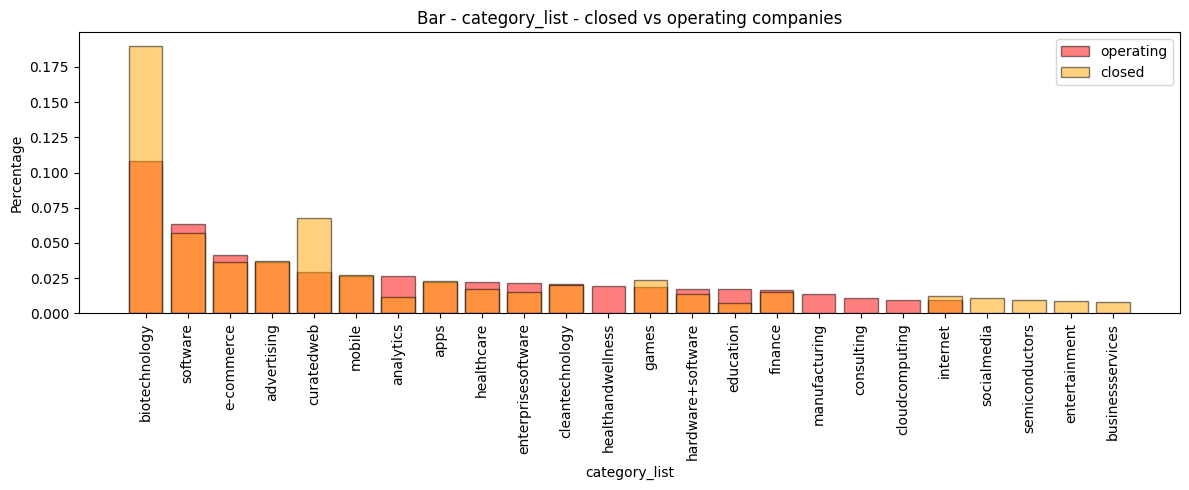

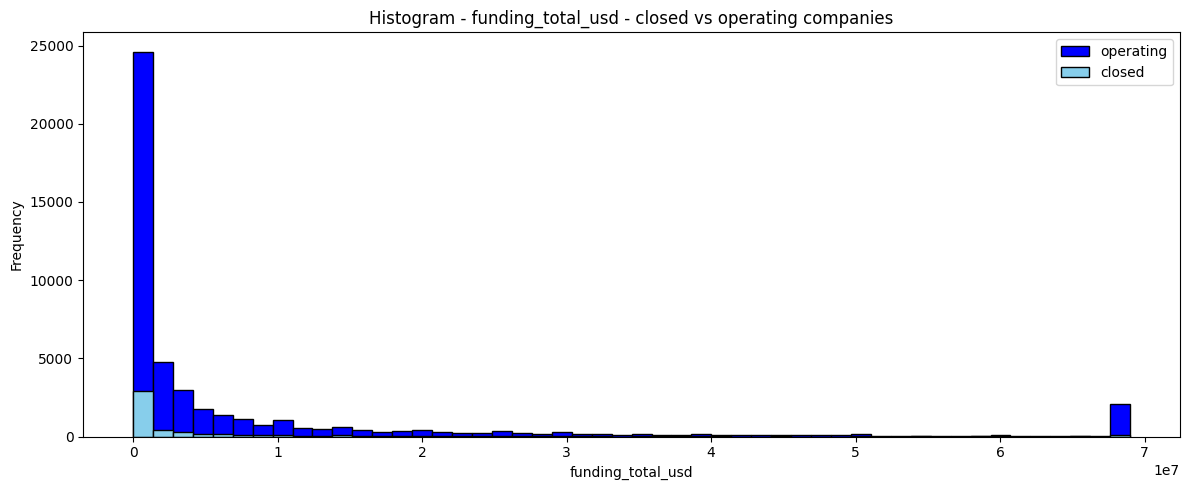

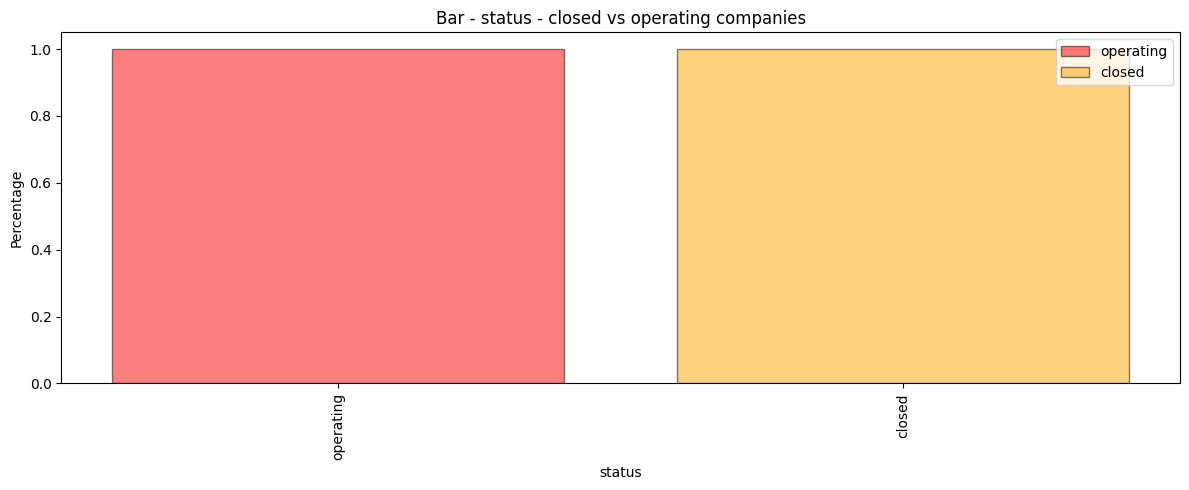

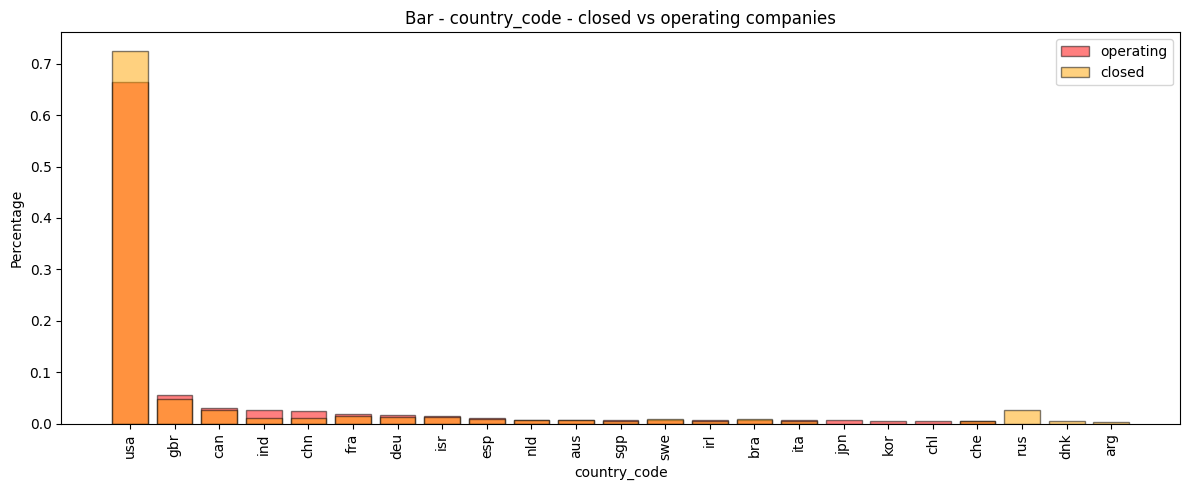

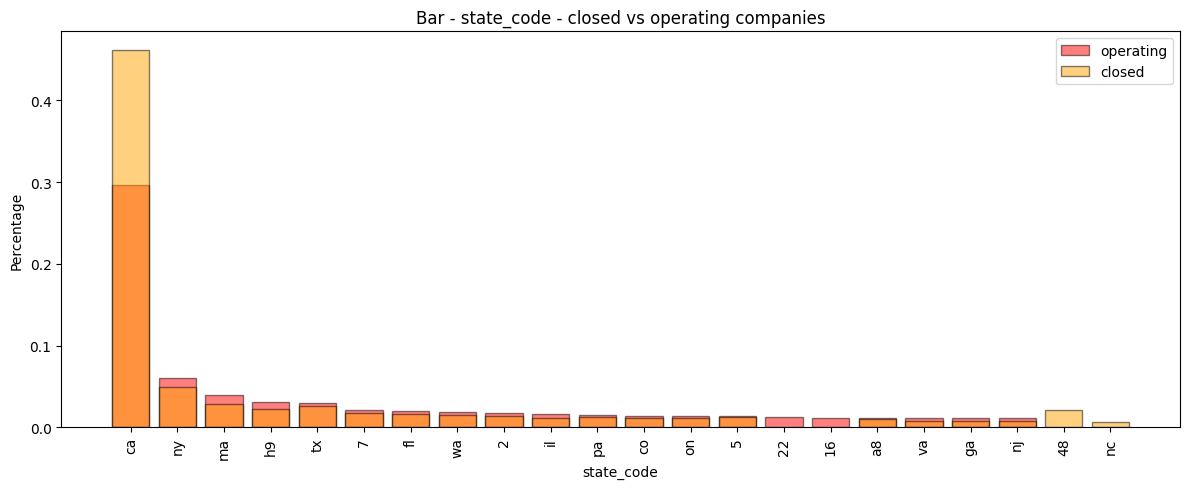

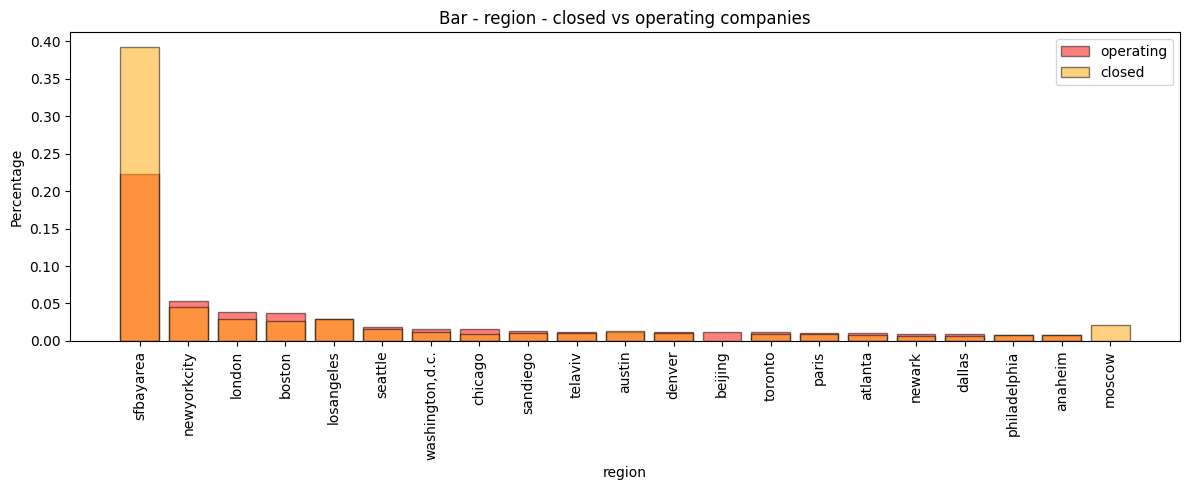

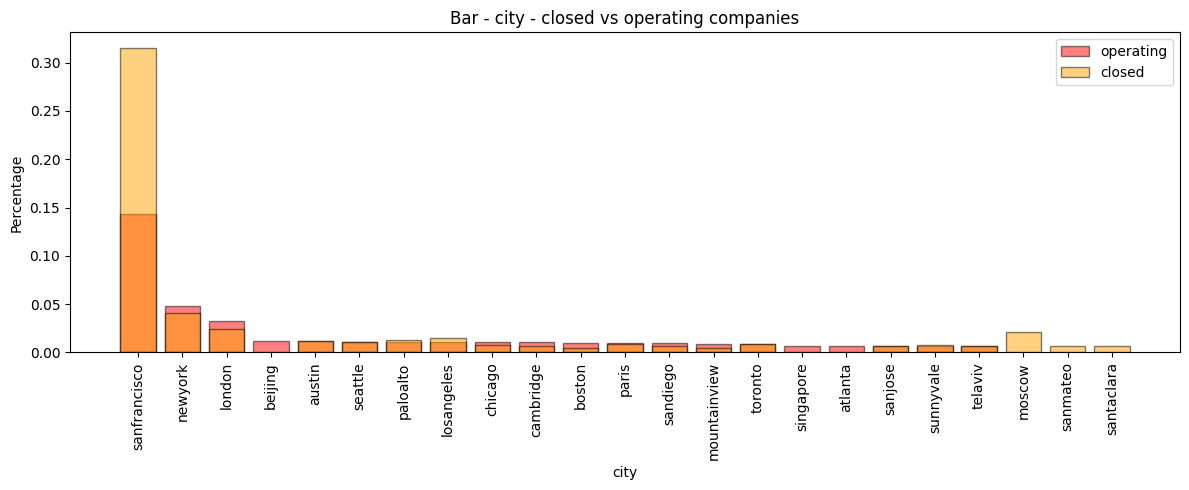

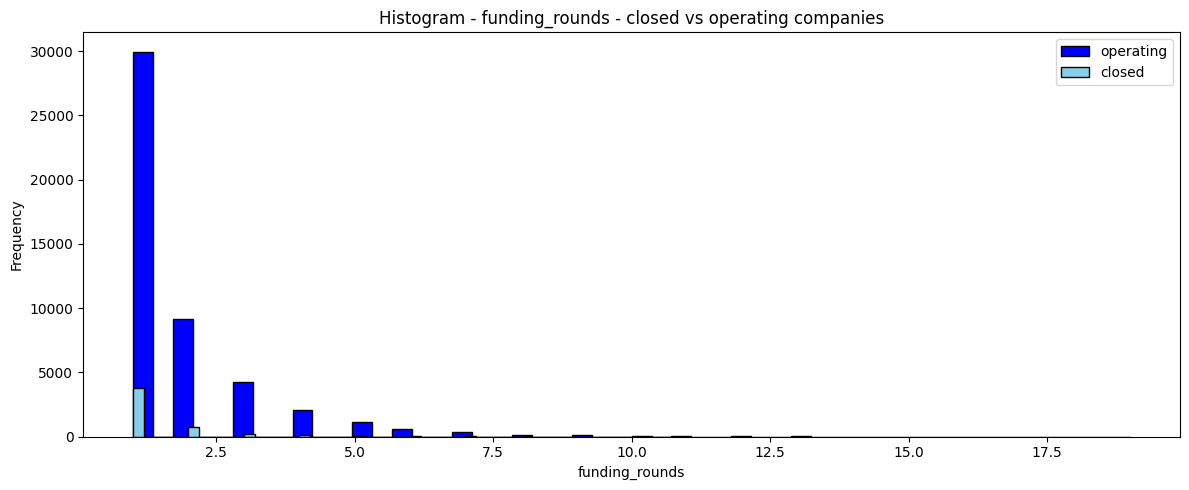

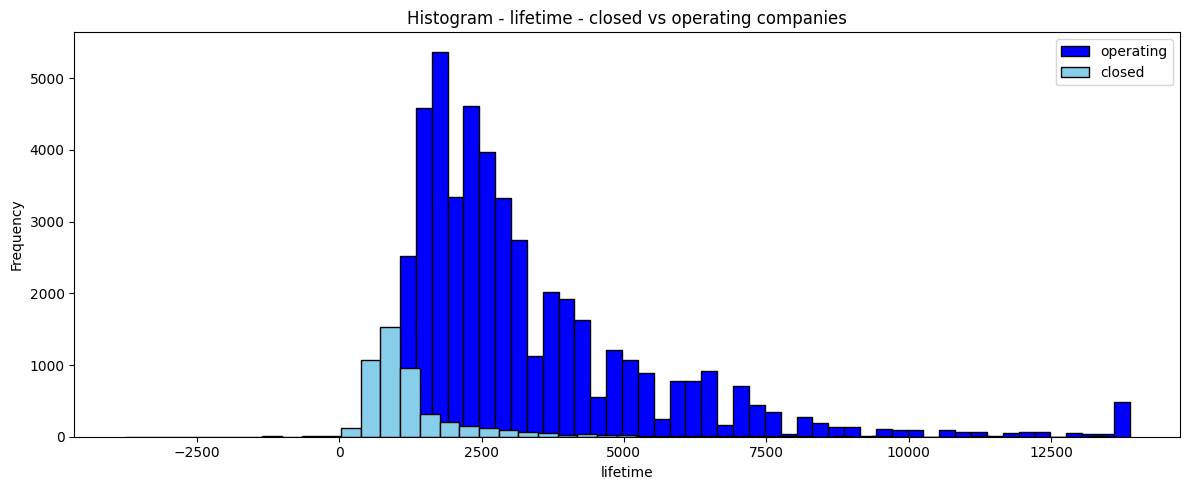

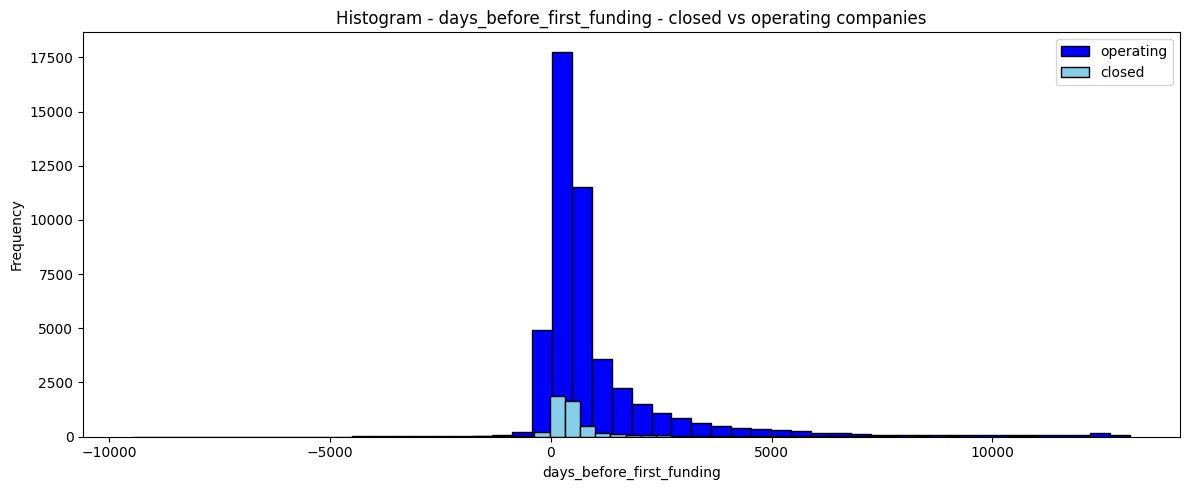

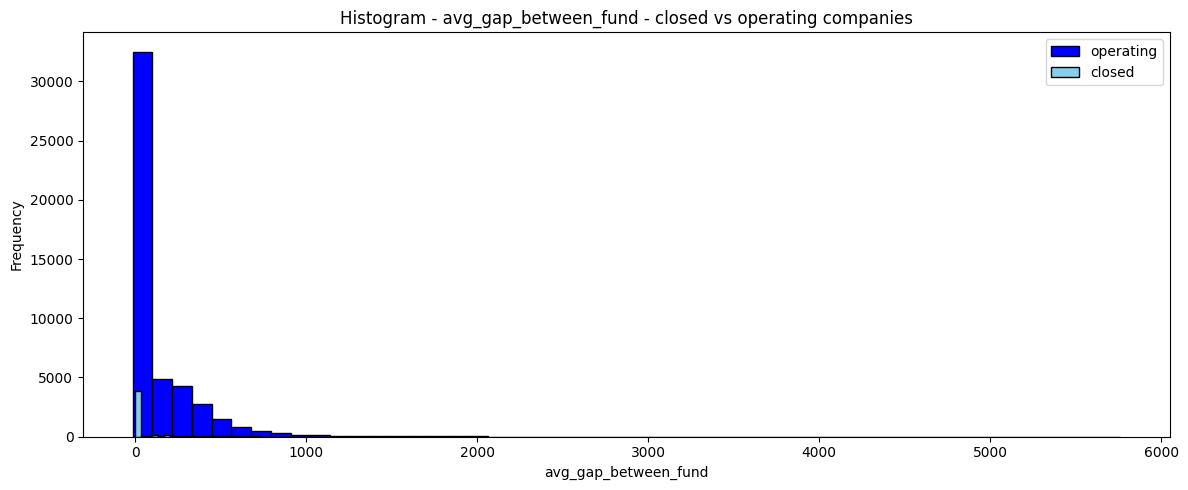

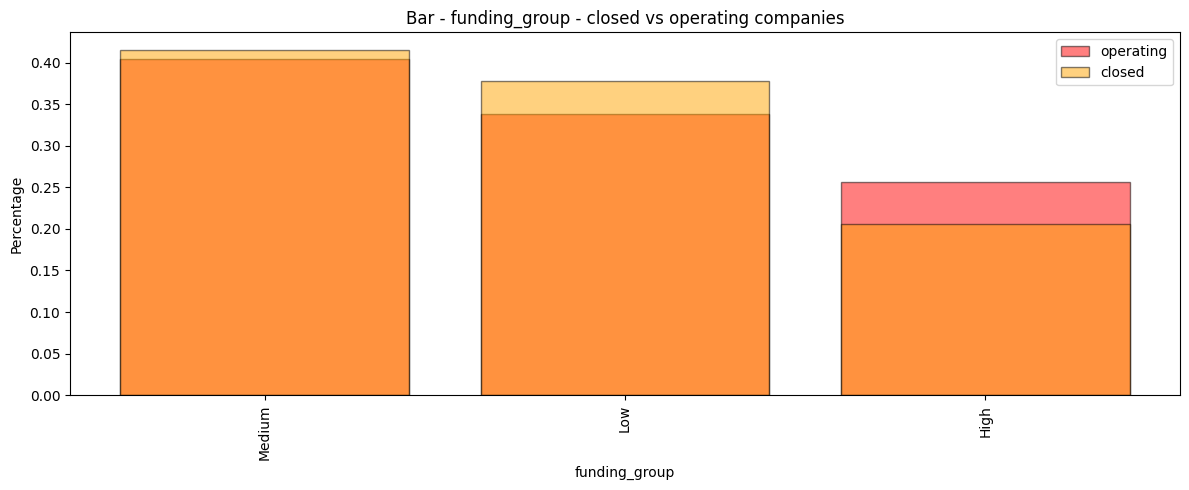

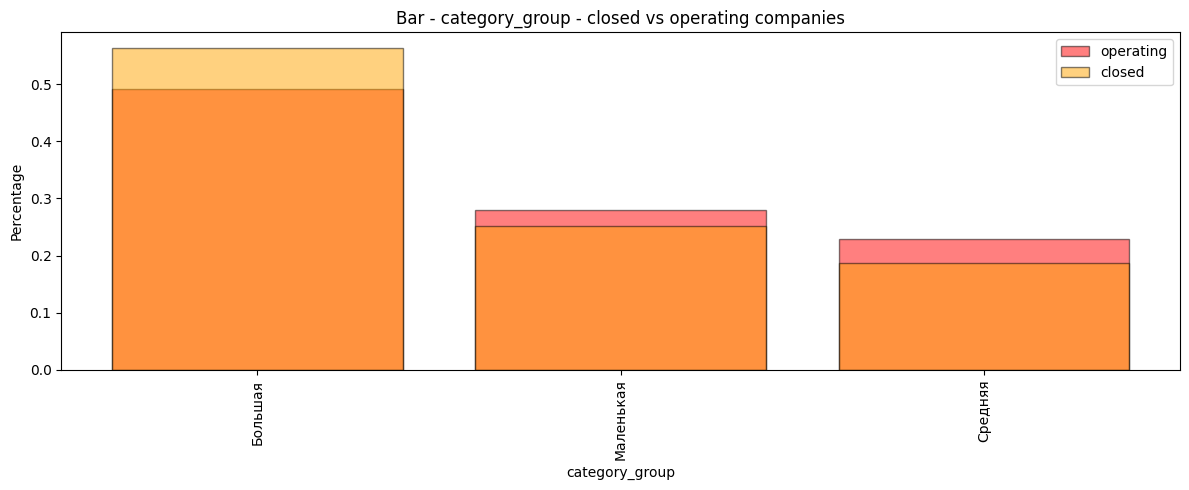

In [47]:
visualize_columns_comparison(startups_train)

In [48]:
startups_train['status'].value_counts()

status
operating    47917
closed        4962
Name: count, dtype: int64

У нас несбалансирования выборка. Доля закрытых компаний в 10 раз ниже, чем открытых. Естественно погрешность в данных и в анализе возрастает при таких условиях. Какие особенности при сравнении двух портретов можно отметить:
1)Средняя продолжительность жизни компании в группе закрытых компаний значительно ниже чем во второй группе и составляет примерно 1000 дней против 2000 дней.
2)На втором месте в группе закрытых компаний категория curatedweb
3) Москва на 3 месте среди других городов в группе закрытых компаний.
В остальных признаках особенных различий не замечено.

Посмотрим на матрицу корреляции Phik

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'days_before_first_funding', 'avg_gap_between_fund']


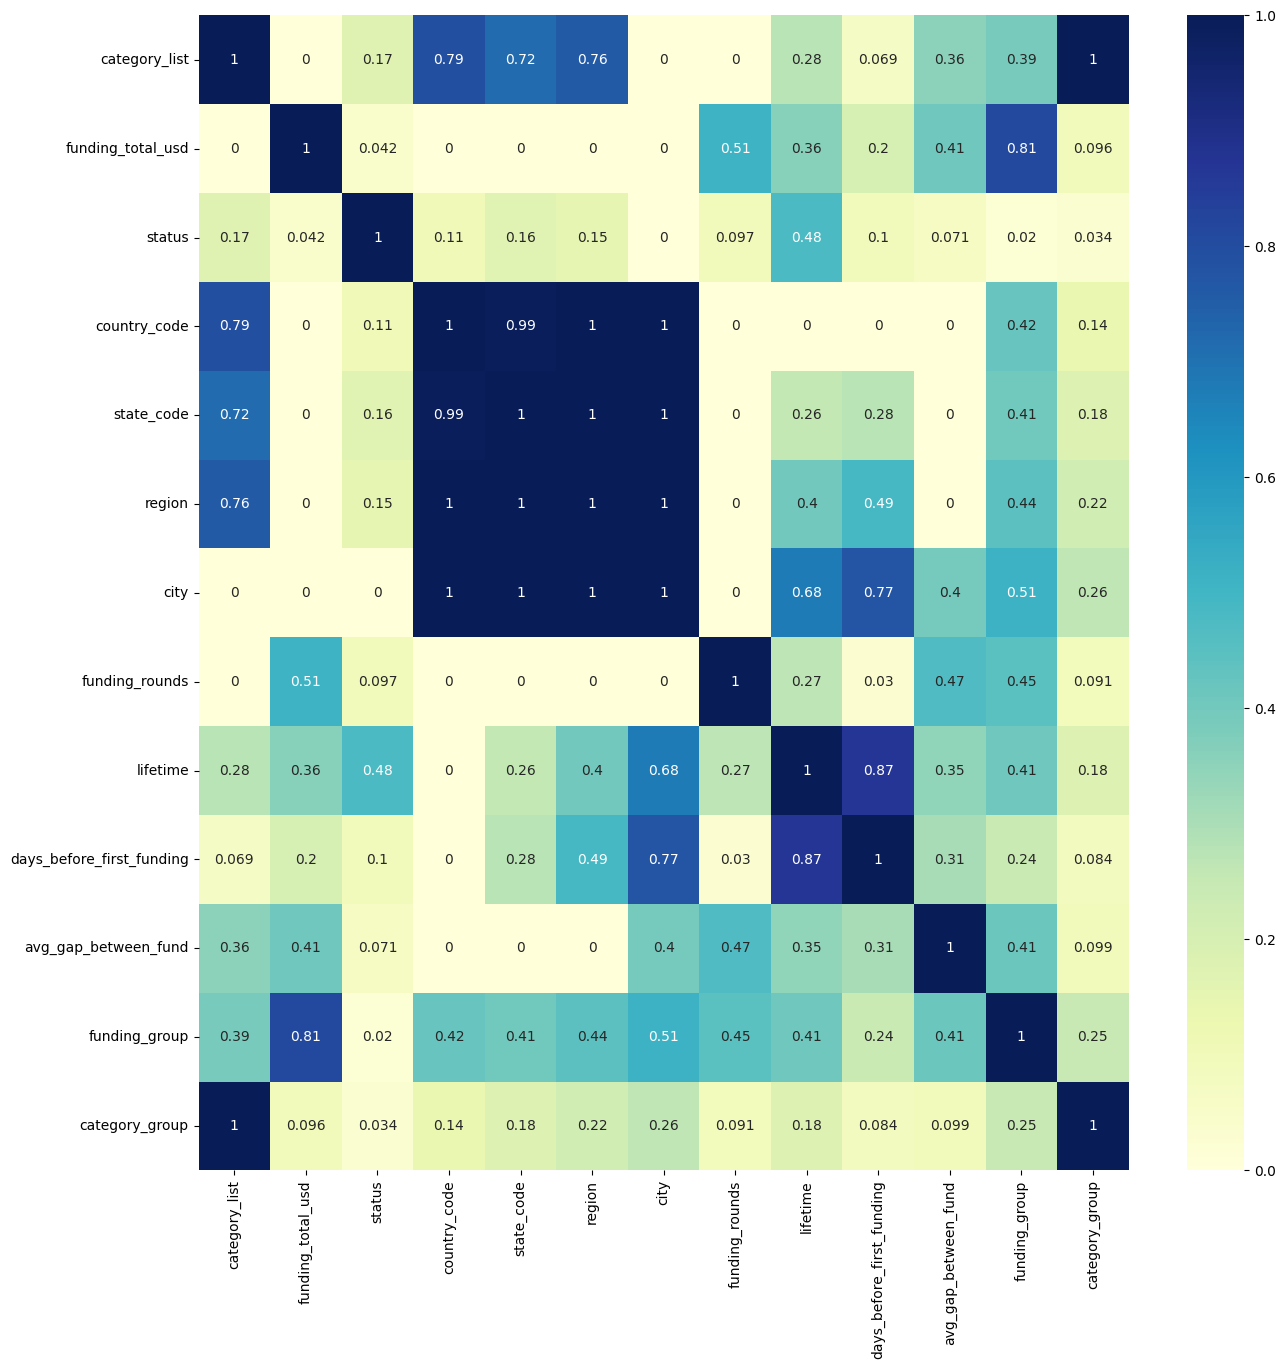

In [49]:
# Построим матрицу корреляции Phik для количественных и качественных признаков
phik_corr_matrix = phik_matrix(startups_train.sample(frac=0.25,random_state=42))
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

В матрице мы видим мультиколлинеарность между признаками регионов, lifetime с days_before_first_fund, category_list с category_group. В таком случае оставим признаки region и lifetime и category_group

In [50]:
startups_train=startups_train.drop(columns=['state_code','days_before_first_funding'])

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'avg_gap_between_fund']


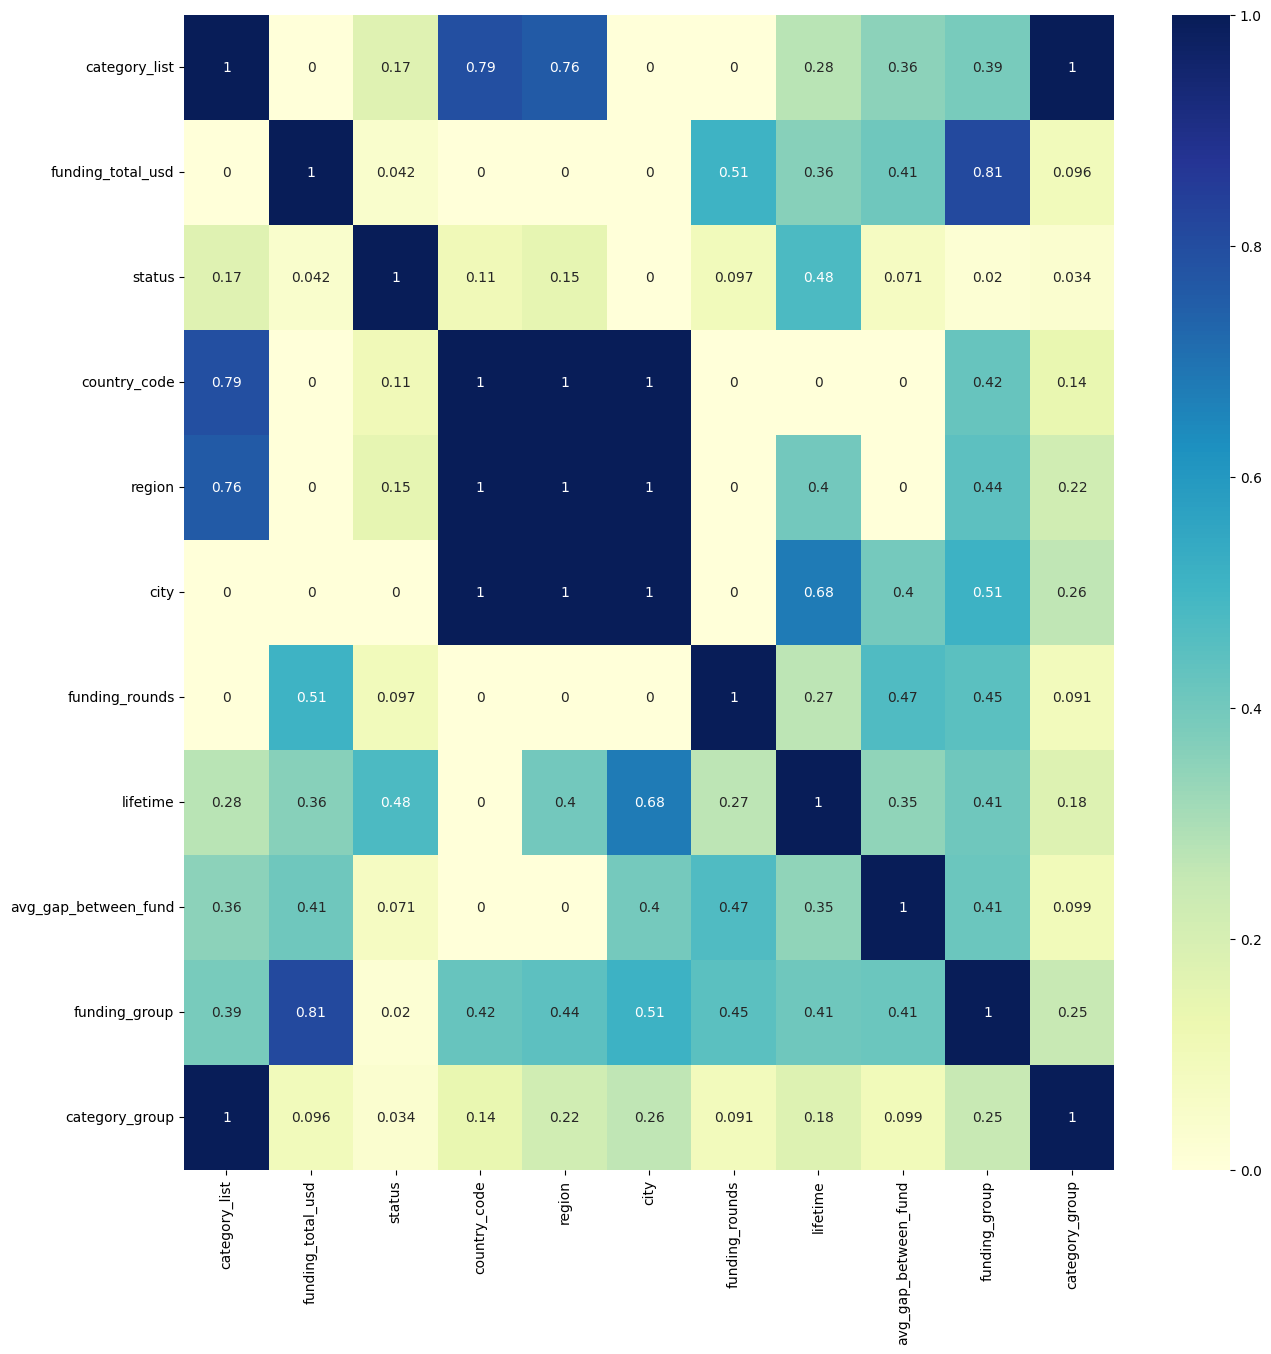

In [51]:
# Построим матрицу корреляции Phik для количественных и качественных признаков
phik_corr_matrix = phik_matrix(startups_train.sample(frac=0.25,random_state=42))
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

*Вывод:* каких-то явных отоличий успешных компаний от неуспешных выявлено не было. В процессе анализа матрицы корреляции были обнаружены и удалены мультиколлинеарные признаки. Можно перейти к построению пайплайна.

## Создание пайплайна

In [52]:
startups_train.head(5)

,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,lifetime,avg_gap_between_fund,funding_group,category_group
name,,,,,,,,,,,
lunchgate,onlinereservations,"828,626.00",operating,che,zurich,zürich,2,2748,655,Low,Маленькая
earlens,manufacturing,"42,935,019.00",operating,usa,sfbayarea,redwoodcity,4,4748,348,High,Средняя
revivapharmaceuticals,biotechnology,"35,456,381.00",operating,usa,sfbayarea,sanjose,3,4383,227,High,Большая
sancilioandcompany,healthcare,"22,250,000.00",operating,usa,sfbayarea,sanfrancisco,3,5114,350,High,Большая
wiretoughcylinders,manufacturing,"1,000,000.00",operating,usa,va-other,bristol,1,2712,0,Medium,Средняя


In [54]:
startups_train['status']=startups_train['status'].replace({'operating':0,'closed':1})
X = startups_train.drop(columns='status')
y = startups_train.status

cat_colunmns = ['country_code','city']
num_columns = ['funding_total_usd', 'lifetime', 'avg_gap_between_fund','funding_rounds' ]
ord_columns=['category_group']


In [55]:
# разделим данные на тренировочные и тестовые, с сохранение стратификации
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[['country_code','city','funding_total_usd', 'lifetime', 'avg_gap_between_fund','funding_rounds','category_group']], y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

,country_code,city,funding_total_usd,lifetime,avg_gap_between_fund,funding_rounds,category_group
name,,,,,,,
ameritechcollege,usa,provo,"6,800,000.00",13880,0,1,Средняя
whitehilltechnologies,can,moncton,"3,396,991.00",1103,0,1,Большая
answerdash,usa,seattle,"5,440,000.00",2192,325,2,Средняя
behavio,usa,sunnyvale,"355,000.00",2029,0,1,Большая
bitdeli,usa,paloalto,"209,999.00",2557,0,1,Большая


In [ ]:
# создадим пайплайн
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
    ,('polynomial', PolynomialFeatures())
])


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [   (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [   (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['Маленькая', 'Средняя','Большая']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [ ]:
RANDOM_STATE=42
preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_colunmns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipeline, num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# Создадим итоговый пайплайн, который соединит в себе обработку данных и моедлирование
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', LogisticRegression(C=1, class_weight='balanced',penalty='l1', random_state=42,
                                    solver='liblinear'))
    ]
)
pipe_final.fit(X_train, y_train)
# словарь с гиперпараметрами для каждой модели
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(class_weight='balanced',random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(class_weight='balanced',random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [None, 10, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

    # словарь для модели LogisticRegression()
#    ,{
#        'models': [LogisticRegression(
#            random_state=RANDOM_STATE,class_weight='balanced',
#            penalty='l1',
 #           solver='liblinear',

#        )],
#        'models__C': range(1,7),
#        'models__solver': ['liblinear', 'saga' ],
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
 #   }
]

grid_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model=grid_search.best_estimator_
best_params=grid_search.best_params_

# обучим лучшую модель
best_model.fit(X_train, y_train)

print('Лучшие модель и гиперпараметры:\n\n', best_params)

Лучшие модель и гиперпараметры:

 {'preprocessor__num__scaler': MinMaxScaler(), 'models__n_estimators': 50, 'models__min_samples_split': 10, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models': RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=50, random_state=42)}


In [ ]:
best_model.predict(X_test)
y_pred=best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      9584
           1       0.53      0.72      0.61       992

    accuracy                           0.91     10576
   macro avg       0.75      0.83      0.78     10576
weighted avg       0.93      0.91      0.92     10576


Средняя метрика f1 получилась 0.92. Результат удовлетворительный

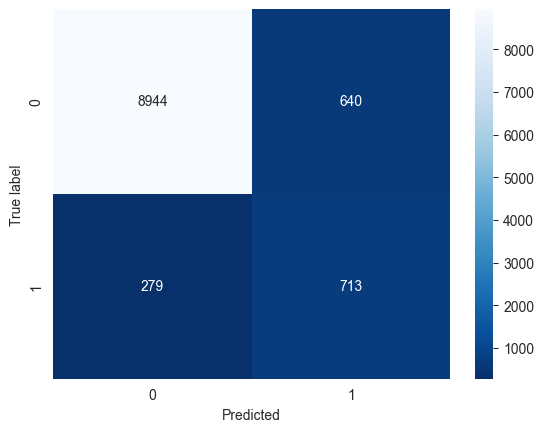

In [ ]:
# создадим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Модель примерно в 37% случаях ошибается при угадывании первого класса(closed). Конечно, это не очень хорошо.

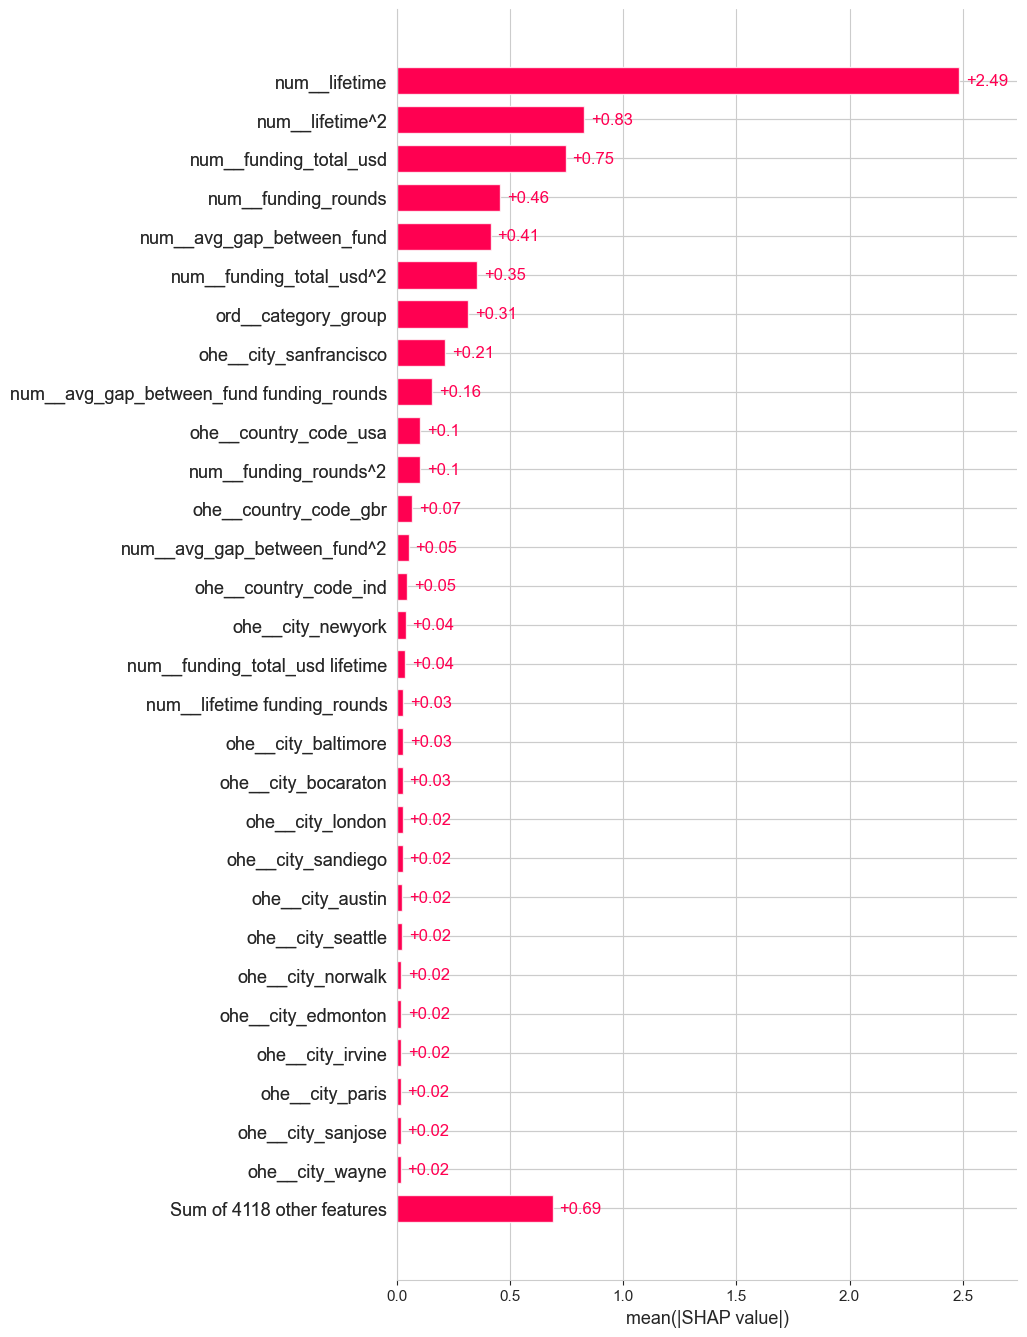

None

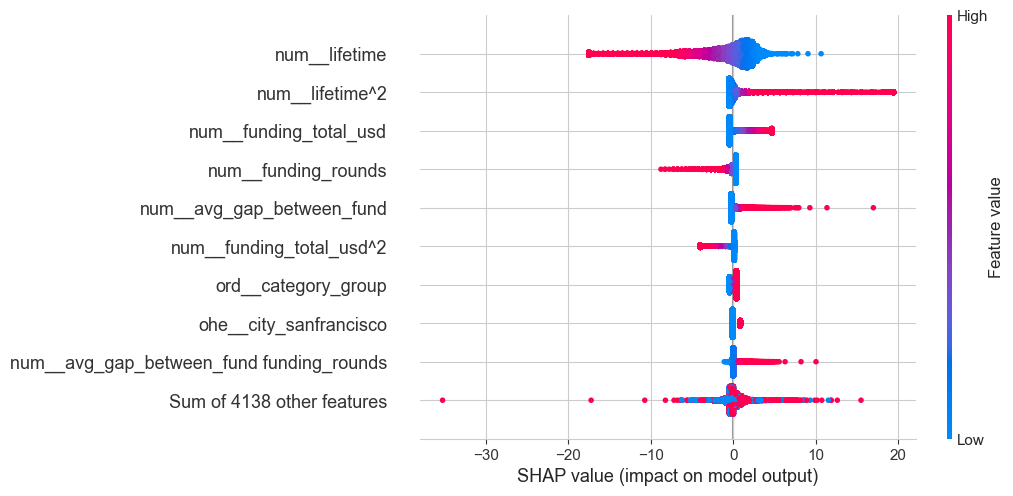

In [ ]:
# изучим влияние признаков на целевой признак
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_train_2 = pd.DataFrame(X_train_2, columns=feature_names)

explainer=shap.LinearExplainer(pipe_final.named_steps['models'], X_train_2)
shap_values = explainer(X_train_2)

display(shap.plots.bar(shap_values, max_display=30))
shap.plots.beeswarm(shap_values)

## Подготовка проверочных данных для загрузки на kaggle

In [ ]:
# создадим функцию для обработки тестовго датасета
def preprocess_startups(startups_test):
    # Обработаем пропуски в географии
    startups_test['country_code'] = startups_test['country_code'].fillna(startups_test['country_code'].mode()[0])
    startups_test['region'] = startups_test.groupby('country_code')['region'].transform(
        lambda x: x.fillna(x.mode(dropna=True).iloc[0] if not x.mode(dropna=True).empty else startups_test['region'].mode().iloc[0]))
    startups_test['state_code'] = startups_test.groupby('region')['state_code'].transform(
        lambda x: x.fillna(x.mode(dropna=True).iloc[0] if not x.mode(dropna=True).empty else startups_test['state_code'].mode().iloc[0]))
    startups_test['city'] = startups_test.groupby('region')['city'].transform(
        lambda x: x.fillna(x.mode(dropna=True).iloc[0] if not x.mode(dropna=True).empty else startups_test['city'].mode().iloc[0]))

    # Пропуск в name заменим на NA
    startups_test['name'] = startups_test['name'].fillna('NA')

    # Обработаем признаки с датами
    startups_test['founded_at'] = startups_test['founded_at'].apply(lambda x: x.replace(year=1980) if x.year < 1980 else x)
    startups_test['founded_at'] = startups_test['founded_at'].apply(lambda x: x.replace(year=2018) if x.year > 2018 else x)
    startups_test['closed_at'] = startups_test['closed_at'].apply(lambda x: x.replace(year=1980) if x.year < 1980 else x)
    startups_test['closed_at'] = startups_test['closed_at'].apply(lambda x: x.replace(year=2018) if x.year > 2018 else x)
    startups_test['last_funding_at'] = startups_test['last_funding_at'].apply(lambda x: x.replace(year=2018) if x.year > 2018 else x)

    startups_test['first_funding_at'] = startups_test['first_funding_at'].fillna(startups_test['founded_at'])
    startups_test['last_funding_at'] = startups_test['last_funding_at'].fillna(startups_test['closed_at'])
    startups_test['closed_at'] = startups_test['closed_at'].fillna(pd.to_datetime('2018-01-01'))

    # Создадим признак lifetime
    startups_test['lifetime'] = (startups_test['closed_at'] - startups_test['founded_at']).dt.days

    # Создадим признак days_before_first_funding
    startups_test['days_before_first_funding'] = (startups_test['first_funding_at'] - startups_test['founded_at']).dt.days

    # Создадим признак средняя длительность между раундами финансирования
    startups_test['avg_gap_between_fund'] = ((startups_test['last_funding_at'] - startups_test['first_funding_at']) / startups_test['funding_rounds']).dt.days

    startups_test = startups_test.drop(columns=['first_funding_at', 'last_funding_at', 'closed_at', 'founded_at'])

    startups_test.loc[startups_test['funding_total_usd'] > startups_test['funding_total_usd'].quantile(0.95),
                      'funding_total_usd'] = startups_test['funding_total_usd'].quantile(0.95)

    # Пропуски заменим медианой группируя данные по стране и кол-ву раундов
    startups_test['funding_total_usd'] = startups_test.groupby(['country_code', 'funding_rounds'])[
        'funding_total_usd'].transform(lambda x: x.fillna(x.median()))
    startups_test['funding_total_usd'] = startups_test.groupby(['funding_rounds'])['funding_total_usd'].transform(
        lambda x: x.fillna(x.median()))

    startups_test['category_list'] = startups_test['category_list'].apply(
        lambda x: x[:x.find('|')] if isinstance(x, str) and x.find('|') > 0 else x)

    # Пропуски в category_list заполним медианой
    startups_test['category_list'] = startups_test['category_list'].fillna(startups_test['category_list'].mode()[0])

    # Создание нового столбца на основе функции categorize_category
    startups_test['category_group'] = startups_test['category_list'].apply(categorize_category)

    # Сделаем столбец name индексом
    startups_test.set_index('name', inplace=True)

    return startups_test[['country_code', 'city', 'funding_total_usd', 'lifetime', 'avg_gap_between_fund',
                          'funding_rounds', 'category_group']]

In [ ]:
startups_test=preprocess_startups(startups_test)

In [ ]:
startups_test.head()

,country_code,city,funding_total_usd,lifetime,avg_gap_between_fund,funding_rounds,category_group
name,,,,,,,
crystalsol,nic,sanfrancisco,"2,819,200.00",3501,0,1,Большая
jbifish&wings,usa,humboldt,"1,000,000.00",2717,0,1,Средняя
coinplus,lux,esch-sur-alzette,"428,257.00",1295,63,2,Большая
imaginecommunications,usa,sandiego,"34,700,000.00",4748,483,4,Большая
dna13,can,ottawa,"4,530,000.00",6209,0,1,Большая


In [ ]:
startups_test['status']=best_model.predict(startups_test)
startups_test['status']=startups_test['status'].apply(lambda x: 'closed' if x else 'operating')

In [ ]:
startups_test.head()

,country_code,city,funding_total_usd,lifetime,avg_gap_between_fund,funding_rounds,category_group,status
name,,,,,,,,
crystalsol,nic,sanfrancisco,"2,819,200.00",3501,0,1,Большая,operating
jbifish&wings,usa,humboldt,"1,000,000.00",2717,0,1,Средняя,operating
coinplus,lux,esch-sur-alzette,"428,257.00",1295,63,2,Большая,closed
imaginecommunications,usa,sandiego,"34,700,000.00",4748,483,4,Большая,operating
dna13,can,ottawa,"4,530,000.00",6209,0,1,Большая,operating


In [ ]:
startups_test=startups_test[['status']]

In [ ]:
# сохраним датасет для загрузки на kaggle
startups_test.to_csv('startups_test.csv', index=True)

## Заключительная глава

В итоге был реализован проект, целью которого является построение модели прогнозирующей успешность компании (закроется она или нет).
В ходе реализации проекта была выполнена предобработка данных, добавлены новые признаки вместо признаков-дат: продолжительность жизни компании, среднее кол-во дней между раундами финансирования, кол-во дней от открытия компании до первого финансирования. Так как категорий достаточно много, был добавлен признак category_group, которых состоит из 3 уникальных значений в зависимости от популярности категории: 1 - самын популярные категории, 2 - категории средней популярности, 3- непопулярные категории.
Был проведен исследовательский анализ и составление портретов двух групп - открытые компании и закрытые компании. В ходе сравнения выделены следующие особенности:
1)Средняя продолжительность жизни компании в группе закрытых компаний значительно ниже чем во второй группе и составляет примерно 1000 дней против 2000 дней.
2)На втором месте в группе закрытых компаний категория curatedweb
3) Москва на 3 месте среди других городов в группе закрытых компаний.
В остальных признаках особенных различий не замечено.
Кодирование категориальных признаков, масштабирование количественных, построение модели было обернуто в пайплайн. Подбор параметров производился с помощью Randomizedgridsearch. В итоге лучшей моделью оказалась RandomForestClassifier со следующими гиперпараметрами: 'preprocessor__num__scaler': MinMaxScaler(), 'models__n_estimators': 50, 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_depth': 20.
Итоговая метрика f1 для тестовой выборки получилась на уровне 0.62.